<a href="https://colab.research.google.com/github/UtharaS123/Pneumonia-detection/blob/main/Pneumonia_detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [2]:
!pip install -q kaggle

from google.colab import files
files.upload()  # Upload your kaggle.json here


Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"utharas","key":"6979d2c322fefc0baa393a33cc84d062"}'}

In [3]:
!mkdir -p ~/.kaggle
!mv kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json


In [4]:
!kaggle datasets download -d paultimothymooney/chest-xray-pneumonia

Dataset URL: https://www.kaggle.com/datasets/paultimothymooney/chest-xray-pneumonia
License(s): other
 99% 2.27G/2.29G [00:15<00:00, 119MB/s]
100% 2.29G/2.29G [00:15<00:00, 154MB/s]


In [5]:
!unzip -q chest-xray-pneumonia.zip -d /content/dataset

In [6]:
#importing libraries
import tensorflow as tf
from tensorflow.keras.layers import Input, Lambda, Dense, Flatten
from tensorflow.keras.models import Model
from tensorflow.keras.applications.vgg16 import VGG16, preprocess_input
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import numpy as np
import matplotlib.pyplot as plt
from glob import glob
import os

In [7]:
train_path = '/content/dataset/chest_xray/train'
valid_path = '/content/dataset/chest_xray/test'

In [8]:
# re-size all the images to this
IMAGE_SIZE = [224, 224]

In [9]:
# add preprocessing layer to the front of VGG
vgg = VGG16(input_shape=IMAGE_SIZE + [3], weights='imagenet', include_top=False)


58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [10]:
# don't train existing weights
for layer in vgg.layers:
  layer.trainable = False

In [11]:
# Number of classes
folders = glob(os.path.join(train_path, '*'))
num_classes = len(folders)
print(f"Number of classes: {num_classes}")

Number of classes: 2


In [12]:
# our layers - you can add more if you want
x = Flatten()(vgg.output)
# x = Dense(1000, activation='relu')(x)
prediction = Dense(len(folders), activation='softmax')(x)

In [13]:
# create a model object
model = Model(inputs=vgg.input, outputs=prediction)
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv1 (Conv2D)           │ (None, 224, 224, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv2 (Conv2D)           │ (None, 224, 224, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_pool (MaxPooling2D)      │ (None, 112, 112, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv1 (Conv2D)           │ (None, 112, 112, 128)  │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv2 (Conv2D)           │ (None, 112, 112, 128)  │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_pool (MaxPooling2D)      │ (None, 56, 56, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv1 (Conv2D)           │ (None, 56, 56, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv2 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv3 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_pool (MaxPooling2D)      │ (None, 28, 28, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv1 (Conv2D)           │ (None, 28, 28, 512)    │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv2 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv3 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_pool (MaxPooling2D)      │ (None, 14, 14, 512)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv1 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv2 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv3 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_pool (MaxPooling2D)      │ (None, 7, 7, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 25088)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 2)              │        50,178 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 14,764,866 (56.32 MB)

 Trainable params: 50,178 (196.01 KB)

 Non-trainable params: 14,714,688 (56.13 MB)

In [14]:
# Compile model
model.compile(
  loss='categorical_crossentropy',
  optimizer='adam',
  metrics=['accuracy']
)



In [15]:
# Data augmentation

train_datagen = ImageDataGenerator(rescale = 1./255,
                                   shear_range = 0.2,
                                   zoom_range = 0.2,
                                   horizontal_flip = True)
test_datagen = ImageDataGenerator(rescale = 1./255)

training_set = train_datagen.flow_from_directory('/content/dataset/chest_xray/train',
                                                 target_size = (224, 224),
                                                 batch_size = 32,
                                                 class_mode = 'categorical')

test_set = test_datagen.flow_from_directory('/content/dataset/chest_xray/test',
                                            target_size = (224, 224),
                                            batch_size = 32,
                                            class_mode = 'categorical')

Found 5216 images belonging to 2 classes.
Found 624 images belonging to 2 classes.


In [16]:
# fit the model
r = model.fit(
  training_set,
  validation_data=test_set,
  epochs=5,
  steps_per_epoch=len(training_set),
  validation_steps=len(test_set)
)


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/5
163/163 ━━━━━━━━━━━━━━━━━━━━ 0s 638ms/step - accuracy: 0.8818 - loss: 0.3023

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


163/163 ━━━━━━━━━━━━━━━━━━━━ 132s 726ms/step - accuracy: 0.8821 - loss: 0.3016 - val_accuracy: 0.8718 - val_loss: 0.3759
Epoch 2/5
163/163 ━━━━━━━━━━━━━━━━━━━━ 116s 710ms/step - accuracy: 0.9605 - loss: 0.1113 - val_accuracy: 0.9054 - val_loss: 0.2743
Epoch 3/5
163/163 ━━━━━━━━━━━━━━━━━━━━ 109s 671ms/step - accuracy: 0.9494 - loss: 0.1267 - val_accuracy: 0.9119 - val_loss: 0.2680
Epoch 4/5
163/163 ━━━━━━━━━━━━━━━━━━━━ 111s 682ms/step - accuracy: 0.9656 - loss: 0.0858 - val_accuracy: 0.9038 - val_loss: 0.3013
Epoch 5/5
163/163 ━━━━━━━━━━━━━━━━━━━━ 111s 676ms/step - accuracy: 0.9722 - loss: 0.0748 - val_accuracy: 0.8878 - val_loss: 0.4128


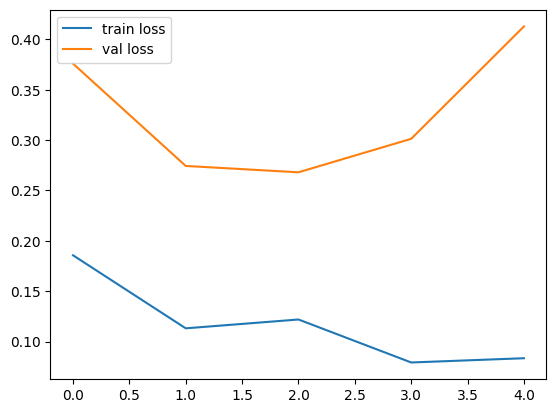

<Figure size 640x480 with 0 Axes>

In [17]:
# loss
plt.plot(r.history['loss'], label='train loss')
plt.plot(r.history['val_loss'], label='val loss')
plt.legend()
plt.show()
plt.savefig('LossVal_loss')


In [18]:
# accuracies
plt.plot(r.history['acc'], label='train acc')
plt.plot(r.history['val_acc'], label='val acc')
plt.legend()
plt.show()
plt.savefig('AccVal_acc')

KeyError: 'acc'

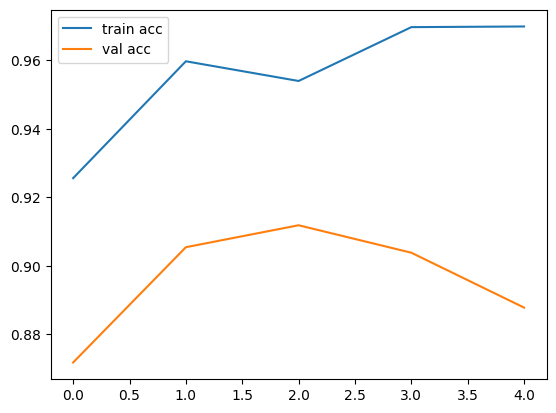

In [19]:
# Plot accuracy
plt.figure()
plt.plot(r.history['accuracy'], label='train acc')
plt.plot(r.history['val_accuracy'], label='val acc')
plt.legend()
plt.savefig('accuracy_plot.png')
plt.show()

In [20]:
# Save model
model.save('model_vgg19.h5')